In [1]:
import tensorflow as tf 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
# Model improvement and Evaluation 
from sklearn import metrics 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score

print('tensorflow version', tf.__version__)

tensorflow version 2.11.0


In [2]:
# import data
bank_data = pd.read_csv("data/matched_data.csv")
bank_data.head()

,cik,fyear,company_name,tic,status_label,current_assets,total_assets,cost_of_goods_sold,total_long_term_debt,depreciation_and_amortization,...,total_revenue,market_value,total_liabilities,net_sales,total_operating_expenses,status,COMPANY_FKEY,FILE_DATE,GOING_CONCERN,OPINION_TEXT1
0,1750,2010.0,AAR CORP,AIR,alive,913.985,1703.727,1408.071,329.802,59.296,...,1775.782,1049.8206,868.438,1775.782,1579.470,0,1750.0,2010.0,0.0,Report of Independent Registered Public Accoun...
1,1750,2011.0,AAR CORP,AIR,alive,1063.272,2195.653,1662.408,669.489,80.333,...,2074.498,485.2897,1329.631,2074.498,1851.805,0,1750.0,2011.0,0.0,Report of Independent Registered Public Accoun...
2,1750,2012.0,AAR CORP,AIR,alive,1033.700,2136.900,1714.500,622.200,108.600,...,2167.100,790.0029,1217.400,2167.100,1921.900,0,1750.0,2012.0,0.0,Report of Independent Registered Public Accoun...
3,1750,2013.0,AAR CORP,AIR,alive,1116.900,2199.500,1581.400,564.300,113.400,...,2035.000,961.3080,1198.800,2035.000,1779.000,0,1750.0,2013.0,0.0,Report of Independent Registered Public Accoun...
4,1750,2014.0,AAR CORP,AIR,alive,954.100,1515.000,1342.700,85.000,92.300,...,1594.300,1046.3954,669.900,1594.300,1510.600,0,1750.0,2014.0,0.0,Report of Independent Registered Public Accoun...


# Balance Data

In [3]:
neg, pos = np.bincount(bank_data['status'])
total = neg + pos
print('Sample distributions:\n    Total: {}\n    Not Bankrupt (0): {} ({:.2f}% of total)\n    Bankrupt (1): {} ({:.2f}% of total)'.format(
    total, neg, (100 * neg) / total, pos, (100 * pos) / total))

Sample distributions:
    Total: 26887
    Not Bankrupt (0): 25874 (96.23% of total)
    Bankrupt (1): 1013 (3.77% of total)


In [4]:
indices = bank_data[bank_data['status'] == 0].index
random_indices = np.random.choice(indices, size=neg-pos, replace=False)
bank_balanced = bank_data.drop(random_indices)

counts = bank_balanced['status'].value_counts()
print(counts)

0    1013
1    1013
Name: status, dtype: int64


## Remove non-numerical

In [13]:
numerical_only = bank_balanced.select_dtypes(include=['float64','int64'])
X = numerical_only.drop(['status','COMPANY_FKEY','FILE_DATE'], axis=1)
y = numerical_only['status']
X.head()

,cik,fyear,current_assets,total_assets,cost_of_goods_sold,total_long_term_debt,depreciation_and_amortization,ebit,ebitda,gross_profit,...,total_current_liabilities,net_income,retained_earnings,total_receivables,total_revenue,market_value,total_liabilities,net_sales,total_operating_expenses,GOING_CONCERN
9,3197,2011.0,53.470,79.345,100.066,9.600,1.399,12.368,13.767,39.126,...,23.609,8.272,-1.049,23.109,139.192,80.5638,36.355,139.192,125.425,0.0
35,1800,2012.0,31322.583,67234.944,12009.511,18085.302,2783.207,9783.515,12566.722,27864.399,...,13280.176,5962.920,20557.318,7612.860,39873.910,103271.6885,40421.712,39873.910,27307.188,0.0
43,2034,2010.0,195.553,231.851,288.821,0.550,2.796,14.099,16.895,57.810,...,74.629,6.581,87.911,85.678,346.631,145.6280,92.207,346.631,329.736,0.0
44,2034,2011.0,198.615,311.665,341.088,48.750,5.502,17.610,23.112,71.340,...,83.186,8.968,98.456,89.108,412.428,178.6202,150.844,412.428,389.316,0.0
45,2034,2012.0,191.969,299.280,355.414,39.052,6.942,27.011,33.953,88.974,...,73.641,16.981,103.663,77.723,444.388,243.2411,131.277,444.388,410.435,0.0


## Split Data

Split data into training testing and validation.
Remove non-numerical values.

In [9]:
from sklearn.model_selection import train_test_split

# split data into training (70%), validation (15%), and testing (15%) sets 
X_, X_test, y_, y_test = train_test_split(X, y, train_size=0.8, test_size=0.15, random_state=42, shuffle=True)
X_train, X_validate, y_train, y_validate = train_test_split(X_, y_, train_size=0.82, test_size=0.18, random_state=42, shuffle=True)

print("y_train data distribution:\n", y_train.value_counts())
print("y_validate data distribution:\n", y_validate.value_counts())
print("y_test data distribution:\n", y_test.value_counts())

input_shape = (X.shape[1],)

y_train data distribution:
 0    667
1    661
Name: status, dtype: int64
y_validate data distribution:
 1    153
0    139
Name: status, dtype: int64
y_test data distribution:
 0    153
1    151
Name: status, dtype: int64


## Define helper functions

In [10]:
def plot_history(history):
    fig, axs = plt.subplots(2, 1, figsize=(24, 16))

    # Plot training & validation accuracy values
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Training Set', 'Validation Set'], loc='upper left')

    # Plot training & validation loss values
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Training Set', 'Validation Set'], loc='upper left')
    
    fig.tight_layout(pad=0.5)

    plt.show()

In [11]:
# display confusion matrix

def plot_cm(cm):
    # Define class labels
    class_labels = ["Not Bankrupt", "Bankrupt"]

    # Create heatmap
    sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

    # Add labels and title
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")

    # Show plot
    plt.show()

## Define model

In [12]:
X_validate.describe()

,cik,fyear,current_assets,total_assets,cost_of_goods_sold,total_long_term_debt,depreciation_and_amortization,ebit,ebitda,gross_profit,...,retained_earnings,total_receivables,total_revenue,market_value,total_liabilities,net_sales,total_operating_expenses,COMPANY_FKEY,FILE_DATE,GOING_CONCERN
count,2.920000e+02,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,...,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,2.920000e+02,292.000000,292.000000
mean,9.555974e+05,2013.571918,625.338363,2274.175483,902.281428,853.375205,115.525264,145.443164,260.968428,531.797144,...,124.402616,162.340202,1434.078572,1916.729939,1629.404106,1434.078572,1173.110144,9.555974e+05,2013.571918,0.143836
std,4.733236e+05,2.323856,2888.590747,7454.788282,2865.726541,2787.819415,358.222249,974.745243,1236.630018,2295.343370,...,2094.377465,522.413011,4704.432159,10353.577693,5116.449013,4704.432159,3826.097887,4.733236e+05,2.323856,0.351525
min,2.034000e+03,2010.000000,0.025000,0.031000,0.006000,0.000000,0.000000,-2006.000000,-1674.000000,-1072.619000,...,-11084.702000,0.000000,0.002000,0.002000,0.110000,0.002000,0.186000,2.034000e+03,2010.000000,0.000000
25%,7.879502e+05,2012.000000,14.449250,28.224000,12.593000,0.000000,0.962750,-9.353250,-4.652500,3.381750,...,-187.444750,2.274500,22.819000,26.326275,15.943750,22.819000,28.482750,7.879502e+05,2012.000000,0.000000
50%,1.048564e+06,2013.000000,97.206000,306.038500,110.074500,38.935500,9.824500,-0.169000,8.487000,62.518000,...,-24.686000,15.903000,173.323000,116.722500,166.958000,173.323000,167.056500,1.048564e+06,2013.000000,0.000000
75%,1.343462e+06,2015.000000,382.772500,1183.999500,662.126250,361.705000,58.969750,60.138000,121.198500,294.760000,...,70.637250,133.028250,1055.769500,769.457800,721.869000,1055.769500,871.669750,1.343462e+06,2015.000000,0.000000
max,1.669812e+06,2018.000000,41692.000000,81812.000000,38504.000000,20030.479000,2931.000000,14343.000000,17274.000000,30613.000000,...,25755.000000,6875.000000,59074.000000,156941.880000,39765.000000,59074.000000,52089.000000,1.669812e+06,2018.000000,1.000000


In [17]:
def binary_classification_model(input_shape=(20,)):
    
    model = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Normalization(),
        tf.keras.layers.Dense(22, activation='relu'),
        # tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        # tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2, activation='softmax'),
        # tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

    model.compile(optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=6, monitor='val_loss')
    ]
    
    return model

### Preform a 1 hot encoding on the binary data to create categories

In [15]:
y_hot_train = tf.one_hot(y_train, 2)
y_hot_val = tf.one_hot(y_validate, 2)
y_hot_test = tf.one_hot(y_test, 2)

In [19]:
callbacks = [
     tf.keras.callbacks.EarlyStopping(patience=6, monitor='val_loss')
]

model = binary_classification_model()
# callbacks4 = create_callbacks('model_checkpoints/model4/', 'epoch', 5)
history4 = model.fit(X_train, y_hot_train,
                    validation_data=(X_validate, y_hot_val),
                    epochs=400,
                    batch_size=24,
                    callbacks=callbacks,
                    # class_weight=class_weight
                    )

Epoch 1/400
56/56 [==============================] - 1s 7ms/step - loss: 227204.0781 - accuracy: 0.4977 - val_loss: 221172.7500 - val_accuracy: 0.5205
Epoch 2/400
56/56 [==============================] - 0s 3ms/step - loss: 223611.5156 - accuracy: 0.4977 - val_loss: 217623.5625 - val_accuracy: 0.5205
Epoch 3/400
56/56 [==============================] - 0s 3ms/step - loss: 220047.1562 - accuracy: 0.4977 - val_loss: 214063.1562 - val_accuracy: 0.5205
Epoch 4/400
56/56 [==============================] - 0s 3ms/step - loss: 216499.1250 - accuracy: 0.4977 - val_loss: 210521.5938 - val_accuracy: 0.5205
Epoch 5/400
56/56 [==============================] - 0s 3ms/step - loss: 212955.9531 - accuracy: 0.4977 - val_loss: 206999.4844 - val_accuracy: 0.5205
Epoch 6/400
56/56 [==============================] - 0s 3ms/step - loss: 209418.1719 - accuracy: 0.4977 - val_loss: 203468.2812 - val_accuracy: 0.5205
Epoch 7/400
56/56 [==============================] - 0s 3ms/step - loss: 205883.3750 - accurac

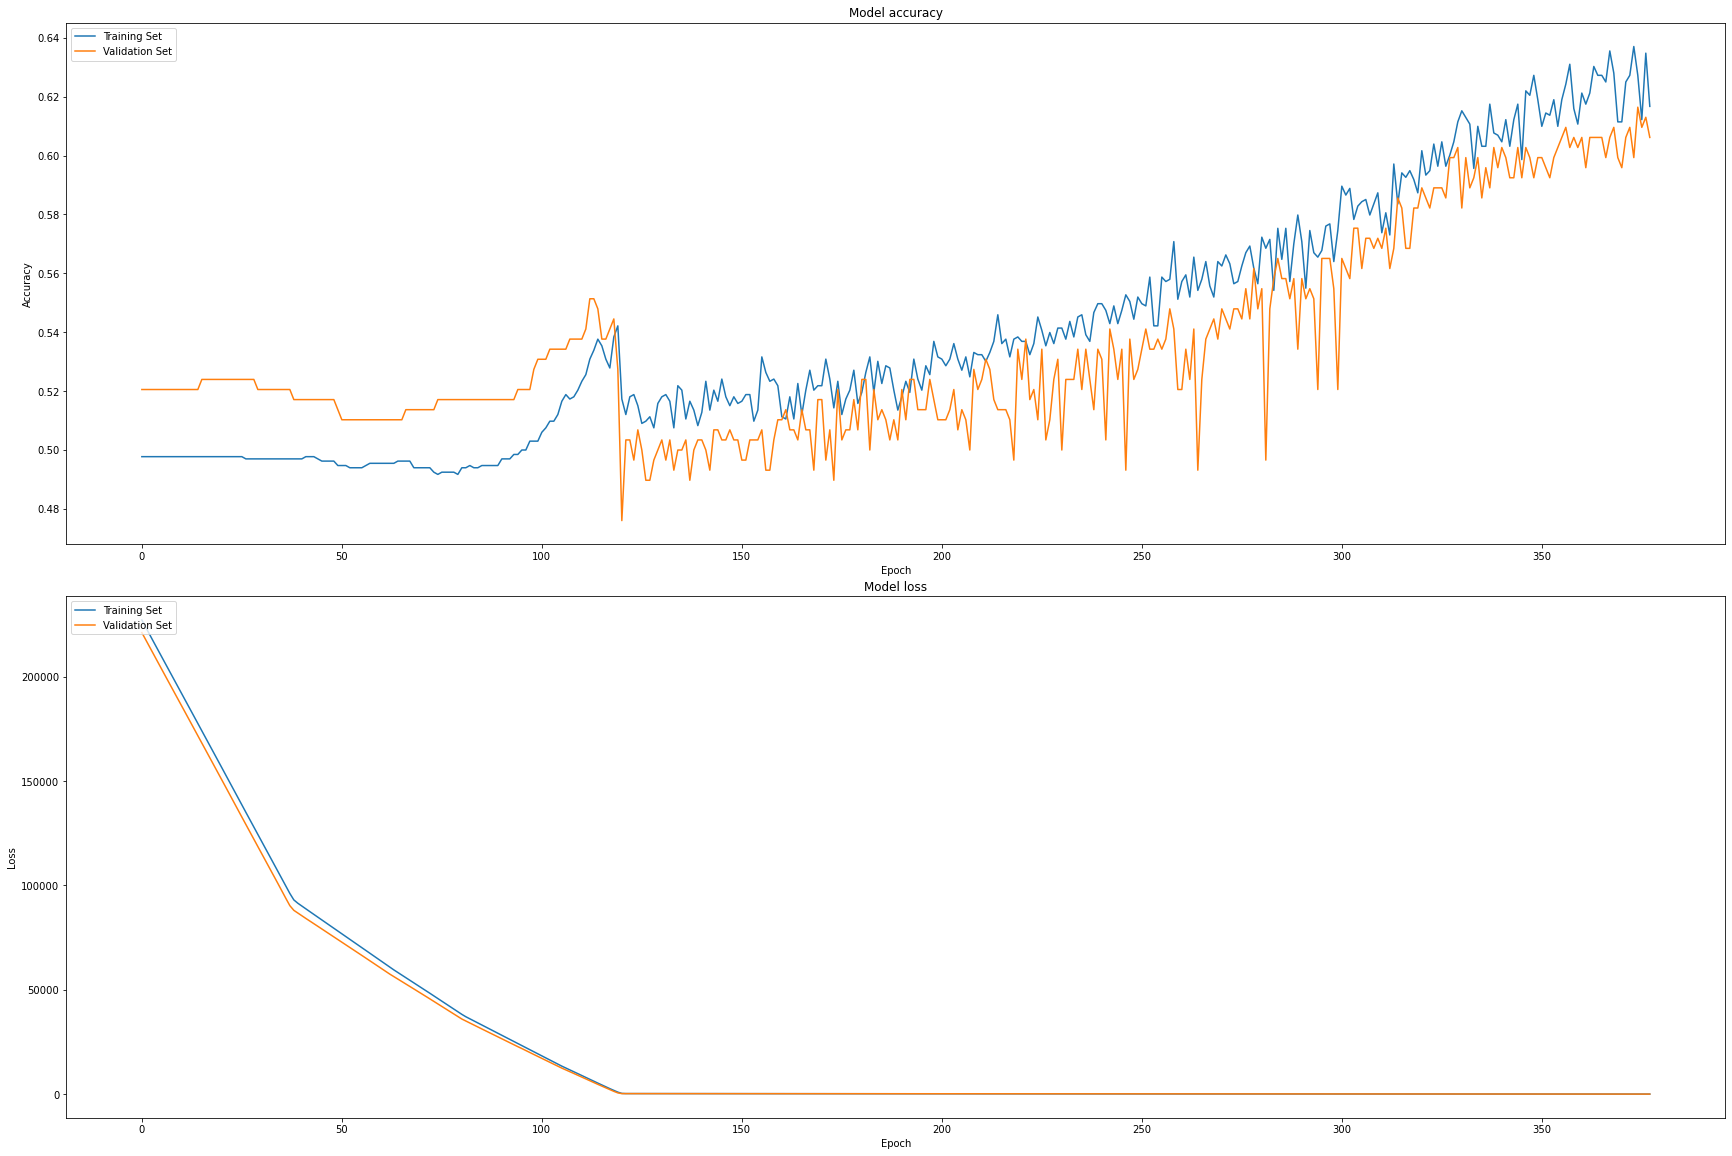

In [20]:
plot_history(history4)

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 23)               47        
 ion)                                                            
                                                                 
 dense_3 (Dense)             (None, 22)                528       
                                                                 
 dense_4 (Dense)             (None, 10)                230       
                                                                 
 dense_5 (Dense)             (None, 2)                 22        
                                                                 
Total params: 827
Trainable params: 780
Non-trainable params: 47
_________________________________________________________________


In [22]:
y_predict_probs = model.predict(X_test)
print(y_predict_probs)

# Convert probabilities to binary predictions using a threshold of 0.5
y_predict = np.round(y_predict_probs)
print(y_predict)

10/10 [==============================] - 0s 1ms/step
[[1.00000000e+00 3.25936986e-11]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 1.53135506e-34]
 [2.40534034e-11 1.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 2.49196282e-30]
 [1.00000000e+00 1.53316596e-13]
 [1.00000000e+00 0.00000000e+00]
 [1.03065453e-36 1.00000000e+00]
 [1.00000000e+00 1.44200421e-18]
 [1.00000000e+00 0.00000000e+00]
 [3.96220439e-30 1.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 1.75331471e-30]
 [3.31049162e-17 1.00000000e+00]
 [0.00000000e+00 1.00000000e+00]
 [1.00000000e+00 1.85214591e-29]
 [1.55275489e-12 1.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 1.24551552e-18]
 [1.00000000e+00 2.28056911e-22]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 3.41589504e-37]
 [8.94076928e-35 1.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 6.8023

In [26]:
# convert categorical to binary
binary_preds_1d = np.argmax(y_predict, axis=1)
print(binary_preds_1d)

precision = precision_score(y_test, binary_preds_1d)
recall = recall_score(y_test, binary_preds_1d)
f1_4 = f1_score(y_test, binary_preds_1d)

print( "precision: ", precision)
print( "recall: ", recall)
print("f1 score: ", f1_4)

[0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 1 1 0 0 1 0 0 1
 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 0 0 0 0 1 1 0
 0 1 0 0 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 0 0 0 1 0 1
 1 0 1 1 0 0 0 1 1 0 0 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 1 1 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0
 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0]
precision:  0.6395348837209303
recall:  0.36423841059602646
f1 score:  0.46413502109704635


[[122  31]
 [ 96  55]]


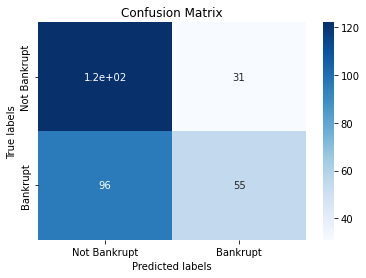

In [27]:
conf_mat = confusion_matrix(y_test, binary_preds_1d)
print(conf_mat)
plot_cm(conf_mat)